In [2]:
import pandas as pd
from google.colab import files
uploaded = files.upload()
df = pd.read_excel('dfupdate.xlsx')
print(df.info())
print(df.head())

Saving dfupdate.xlsx to dfupdate (1).xlsx
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8359 entries, 0 to 8358
Data columns (total 100 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Low Fuel Warning Light                    8359 non-null   bool   
 1   transmission                              8359 non-null   object 
 2   Color                                     8359 non-null   object 
 3   Seat Belt Warning                         8359 non-null   bool   
 4   Rear Brake Type                           8359 non-null   object 
 5   Electronic Multi Tripmeter                8359 non-null   bool   
 6   Air Conditioner                           8359 non-null   bool   
 7   Adjustable Head Lights                    8359 non-null   bool   
 8   km                                        8359 non-null   int64  
 9   city                                      8359 non-null   object

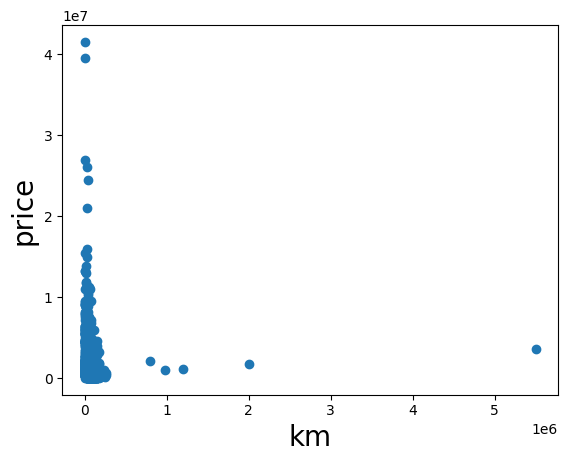

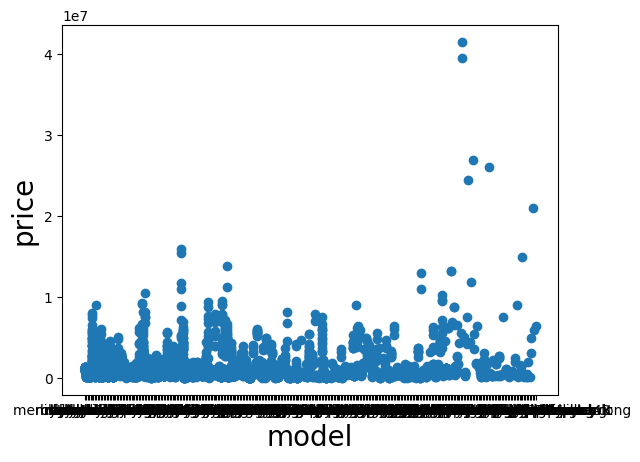

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.scatter(df["km"],df["price"])
plt.xlabel("km", fontsize = 20)
plt.ylabel("price", fontsize = 20)
plt.show()

plt.scatter(df["model"],df["price"])
plt.xlabel("model", fontsize = 20)
plt.ylabel("price", fontsize = 20)
plt.show()

In [4]:
# Function to find outliers and their count using Z-Score and remove the outliers
from scipy.stats import zscore

def find_outliers_zscore_with_count(dataframe, columns, threshold=3):
    outliers_dict = {}
    outliers_indices = set()

    for column in columns:
        z_scores = zscore(dataframe[column])
        outliers = dataframe[abs(z_scores) > threshold]

        outliers_dict[column] = outliers[column].values
        outliers_indices.update(outliers.index)

    return outliers_dict, outliers_indices


columns_to_check = ['Seating Capacity', 'modelYear', 'km']

# Find outliers and their indices
outliers_zscore, outlier_indices = find_outliers_zscore_with_count(df, columns_to_check)


for column, values in outliers_zscore.items():
    print(f"Outliers in {column} (Z-Score): {values} (Count: {len(values)})")


df_cleaned = df.drop(index=outlier_indices)

print("\nCleaned DataFrame:")
print(df_cleaned)



Outliers in Seating Capacity (Z-Score): [ 8  8 10  8  8  8  8  8  8  9  8  8  8  8  8  8  8 10  8  8  8  8  8  8
  9  8  8  8  8  2  8  8  8  2  8  8  8  8  8  8  8  8  8  8  9  8  8  2
  2  8 10  8  8  8  8  8  8  8  8  9  9  8  9  9  8 10 10  8  9  2  8  8
  8  8  9  8  8  8  9  8  8  2  2  9  8] (Count: 85)
Outliers in modelYear (Z-Score): [2002 2002 2004 2002 2002 2003 2004 1995 1995 1998 2004 2003 2004 2003
 2004 2004 2004 2001 2003 2004 2004 2004 2004 2001 2004 2002 2004 2003
 2004 2001 2004 2003 2003 2004 1985 2002 2002 2004 2003 2003 2004 2004
 2001 2004 2001 2004 2001 1999 1999 1998 2004 2003 2004 2001 2001 2002
 1985 2004 2002 2003 2004 2003 2002] (Count: 63)
Outliers in km (Z-Score): [ 800000 5500000 1200000 2000022  975000] (Count: 5)

Cleaned DataFrame:
      Low Fuel Warning Light transmission          Color  Seat Belt Warning  \
0                       True    automatic          black               True   
1                       True       manual           grey         

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib


features = ['km', 'ownerNo', 'Max Power', 'modelYear', 'Seating Capacity', 'Mileage',
            'Fuel Type_Encoded', 'Engine Type_Encoded', 'city_Encoded', 'model_Encoded',
            'bt_Encoded', 'Color_Encoded']
target = 'price'


X = df_cleaned[features]
y = df_cleaned[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1.0))
])


k_values = [2, 3, 5, 7, 10]


cv_accuracies = []
models = []

# Perform cross-validation for each k
for k in k_values:
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=k, scoring='r2')
    cv_accuracies.append(cv_scores.mean())

    pipeline.fit(X_train, y_train)
    models.append(pipeline)

# Find the best model based on the highest cross-validation score (R²)
best_k = k_values[np.argmax(cv_accuracies)]
best_model = models[np.argmax(cv_accuracies)]


print(f"Best k value: {best_k} with R² score: {cv_accuracies[np.argmax(cv_accuracies)] * 100:.2f}%")


train_predicted = best_model.predict(X_train)


test_predicted = best_model.predict(X_test)

train_r2 = r2_score(y_train, train_predicted)
test_r2 = r2_score(y_test, test_predicted)

print(f"\nTraining R-squared (R²): {train_r2 * 100:.2f}%")
print(f"Testing R-squared (R²): {test_r2 * 100:.2f}%")

train_mse = mean_squared_error(y_train, train_predicted)
test_mse = mean_squared_error(y_test, test_predicted)

train_mae = mean_absolute_error(y_train, train_predicted)
test_mae = mean_absolute_error(y_test, test_predicted)

print(f"\nTraining Mean Squared Error (MSE): {train_mse}")
print(f"Testing Mean Squared Error (MSE): {test_mse}")

print(f"\nTraining Mean Absolute Error (MAE): {train_mae}")
print(f"Testing Mean Absolute Error (MAE): {test_mae}")

train_results = pd.DataFrame({
    'Actual': y_train,
    'Predicted': train_predicted
})
test_results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': test_predicted
})

print("\nTraining Predicted vs Actual values:")
print(train_results.head())

print("\nTesting Predicted vs Actual values:")
print(test_results.head())
# Save the trained model to a file
model_filename = "ridge_regression_model.pkl"
joblib.dump(best_model, model_filename)

print(f"Model saved as {model_filename}")

Best k value: 3 with R² score: 87.99%

Training R-squared (R²): 88.62%
Testing R-squared (R²): 90.56%

Training Mean Squared Error (MSE): 215857188689.86014
Testing Mean Squared Error (MSE): 216463815644.38196

Training Mean Absolute Error (MAE): 229942.34604887053
Testing Mean Absolute Error (MAE): 229697.96784366135

Training Predicted vs Actual values:
         Actual     Predicted
439   2600000.0  2.201188e+06
3610   649000.0  6.304611e+05
7804   619000.0  8.588854e+05
6657  1200000.0  1.822225e+06
1509  1895000.0  1.705208e+06

Testing Predicted vs Actual values:
         Actual     Predicted
3666    80000.0 -2.137554e+05
6504  1110000.0  1.776830e+06
5086   616000.0  5.124222e+05
2236   575000.0  5.388856e+05
1628   535000.0  3.292061e+05
Model saved as ridge_regression_model.pkl


Accuracy for k=1 neighbors: 80.45%
Accuracy for k=2 neighbors: 81.33%
Accuracy for k=3 neighbors: 80.70%
Accuracy for k=4 neighbors: 83.94%
Accuracy for k=5 neighbors: 84.66%
Accuracy for k=6 neighbors: 84.26%
Accuracy for k=7 neighbors: 84.03%
Accuracy for k=8 neighbors: 83.64%
Accuracy for k=9 neighbors: 83.52%
Accuracy for k=10 neighbors: 82.71%
Accuracy for k=11 neighbors: 82.21%
Accuracy for k=12 neighbors: 81.95%
Accuracy for k=13 neighbors: 81.63%
Accuracy for k=14 neighbors: 81.33%
Accuracy for k=15 neighbors: 80.89%
Accuracy for k=16 neighbors: 80.53%
Accuracy for k=17 neighbors: 80.44%
Accuracy for k=18 neighbors: 80.21%
Accuracy for k=19 neighbors: 79.97%
Accuracy for k=20 neighbors: 79.73%


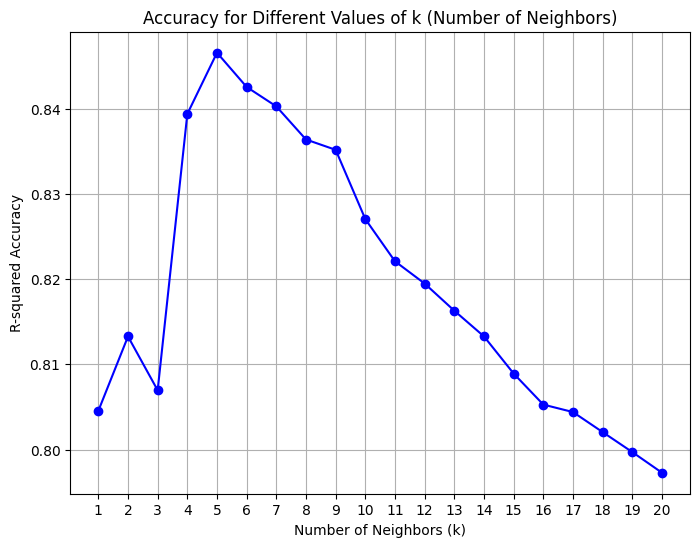


Training R-squared (R²): 88.65%
Testing R-squared (R²): 80.58%

Training Mean Squared Error (MSE): 215224097510.70825
Testing Mean Squared Error (MSE): 445282350641.30023

Training Mean Absolute Error (MAE): 190141.14220057832
Testing Mean Absolute Error (MAE): 252240.9650639075

Training Predicted vs Actual values:
         Actual  Predicted
439   2600000.0  1645000.0
3610   649000.0   562600.0
7804   619000.0   857800.0
6657  1200000.0  1466400.0
1509  1895000.0  1518000.0

Testing Predicted vs Actual values:
         Actual  Predicted
3666    80000.0   148600.0
6504  1110000.0  1366400.0
5086   616000.0   563000.0
2236   575000.0   736200.0
1628   535000.0   486800.0


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

features = ['km', 'ownerNo', 'Max Power', 'modelYear', 'Seating Capacity', 'Mileage',
            'Fuel Type_Encoded', 'Engine Type_Encoded', 'city_Encoded', 'model_Encoded',
            'bt_Encoded', 'Color_Encoded']
target = 'price'

X = df_cleaned[features]
y = df_cleaned[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

k_values = range(1, 21)

cv_accuracies = []

for k in k_values:
    pipeline.set_params(knn__n_neighbors=k)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
    cv_accuracies.append(cv_scores.mean())


for k, accuracy in zip(k_values, cv_accuracies):
    print(f"Accuracy for k={k} neighbors: {accuracy * 100:.2f}%")


plt.figure(figsize=(8, 6))
plt.plot(k_values, cv_accuracies, marker='o', linestyle='-', color='b')
plt.title('Accuracy for Different Values of k (Number of Neighbors)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('R-squared Accuracy')
plt.grid(True)
plt.xticks(k_values)
plt.show()


best_k = k_values[np.argmax(cv_accuracies)]  # Get the k value with the highest R²
best_model = KNeighborsRegressor(n_neighbors=best_k)  # Create a model with the best k


best_model.fit(X_train, y_train)


train_predicted = best_model.predict(X_train)


test_predicted = best_model.predict(X_test)


train_r2 = r2_score(y_train, train_predicted)
test_r2 = r2_score(y_test, test_predicted)


print(f"\nTraining R-squared (R²): {train_r2 * 100:.2f}%")
print(f"Testing R-squared (R²): {test_r2 * 100:.2f}%")

train_mse = mean_squared_error(y_train, train_predicted)
test_mse = mean_squared_error(y_test, test_predicted)

train_mae = mean_absolute_error(y_train, train_predicted)
test_mae = mean_absolute_error(y_test, test_predicted)

print(f"\nTraining Mean Squared Error (MSE): {train_mse}")
print(f"Testing Mean Squared Error (MSE): {test_mse}")

print(f"\nTraining Mean Absolute Error (MAE): {train_mae}")
print(f"Testing Mean Absolute Error (MAE): {test_mae}")

train_results = pd.DataFrame({
    'Actual': y_train,
    'Predicted': train_predicted
})
test_results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': test_predicted
})

print("\nTraining Predicted vs Actual values:")
print(train_results.head())

print("\nTesting Predicted vs Actual values:")
print(test_results.head())
